# Supplemental Figure 14 — Expanded analysis of linker library evolution via POGO-PANCE.


This notebook reproduces **Figure S14** from the supplemental manuscript.

---

### Figure Summary

<div style="text-indent:-2em; padding-left:2em"><strong>(A)</strong> Overview of linker library POGO-PANCE evolution strategy.</div>  
<div style="text-indent:-2em; padding-left:2em"><strong>(B)</strong>Plaque assays of both linker library evolution pools over time.</div>  
<div style="text-indent:-2em; padding-left:2em"><strong>(C)</strong>Identities of single plaques in both pools after passaging in both linker library evolution pools at the left and right linkers.</div>  
<div style="text-indent:-2em; padding-left:2em"><strong>(D)</strong>Enrichment over time in the second pool during POGO-PANCE evolution.</div> 
<div style="text-indent:-2em; padding-left:2em"><strong>(E)</strong>Dotplot comparing enrichment after one mutagenesis passage on the Linker library  versus final enrichment after POGO-PANCE. </div> 

## Notebook Setup
----------------------------

Run the following cell to import all required libraries, define plotting settings, and configure the environment for data analysis and visualization.

In [ ]:
# --- Import necessary modules ---
import os
import sys
os.chdir("..")
import json
import pickle as pkl
from importlib import reload
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats
import scipy
from Bio import SeqIO
import csv
from collections import Counter
from Bio.SeqIO import QualityIO
from utils import dna_rev_comp, translate_dna2aa
from scripts.preprocessing_functions import *
from scripts.plotting import *
import matplotlib.colorbar as mcolorbar 
from scripts.Nanopore_functions import *
from scripts.Illumina_functions import *
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from scripts.linker_analysis_functions  import *


# ======================== PLOTTING SETTINGS ========================

# --- Custom color map for mutation visualization ---
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [
    "#22577A",  # Deep blue
    "#38A3A5",  # Teal
    "#57CC99",  # Medium green
    "#80ED99",  # Bright green
    "#C7F9CC"   # Light pastel green
], N=256)

# --- Seaborn theme configuration ---
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.linewidth": 1
}
sns.set_theme(context="paper", style='ticks', palette="Greys_r", rc=custom_params)

# --- General matplotlib settings ---
fs = 8  # font size
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams.update({
    'font.family': 'Avenir Next',
    'font.weight': 'demi', 
    'font.size': fs,
    'text.color': '#231F20',
    'axes.labelcolor': '#231F20',
    'xtick.color': '#231F20',
    'ytick.color': '#231F20',
    'axes.edgecolor': '#231F20',
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'pdf.fonttype': 42,
    'text.usetex': False
})
sns.set_context("paper", rc={
    "font.size": fs,
    "axes.titlesize": fs + 1,
    "axes.labelsize": fs,
    "axes.linewidth": 1,
    "xtick.labelsize": fs,
    "ytick.labelsize": fs,
    "legend.fontsize": fs,
    "legend.title_fontsize": fs + 1
})

# ======================== LAYOUT PARAMETERS ========================

# --- Pre-defined figure dimensions for multi-panel plots ---
hi = 10.5 * 0.75
wi3 = 2.24
wi2 = 4.76
wi1 = 7.24
nr = 5

# --- Utility for shortening sample names ---
short_fn = np.vectorize(lambda x: x[:5])

## Figure S14A: Overview of linker library POGO-PANCE evolution strategy.
----------------------------

Expanded schematic of the linker library POGO-PANCE evolution strategy from Fig 5G. Two parallel evolution pools (P1 and P2) were initiated from a shared RAMPhaGE-edited linker library using AraC R2 S170-AsLOV2 as the template. Each pool underwent iterative cycles of mutagenesis, negative selection, and positive selection under light and dark conditions. Figure created with Adobe Illustrator.

![Alt Text](/Volumes/ag-niopek/Niopek_Lab/8_Data/1_Nanopore/DMS_analysis/figure_notebooks/figure_illustrations/Figure_S14A.png)

## Figure S14B: Plaque assays of both linker library evolution pools over time.
----------------------------

Plaque assays tracking phage propagation during each selection cycle across both P1 and P2. Dilution series are shown for all four days of mutagenesis and selection.

![Alt Text](/Volumes/ag-niopek/Niopek_Lab/8_Data/1_Nanopore/DMS_analysis/figure_notebooks/figure_illustrations/Figure_S14B.png)

## Figure S14C: Identities of single plaques in both pools after passaging in both linker library evolution pools at the left and right linkers
----------------------------

Genotypic analysis of individual plaques sampled from each pool at the end of evolution. Left and right linker sequences are annotated, with wild-type and SG variants highlighted. Enriched linker residues (e.g., K, Q, N, R) are indicated. 

![Alt Text](/Volumes/ag-niopek/Niopek_Lab/8_Data/1_Nanopore/DMS_analysis/figure_notebooks/figure_illustrations/Figure_S14C.png)

## Figure S14D: Enrichment over time in the second pool during POGO-PANCE evolution.
----------------------------
Temporal enrichment of linker variants in pool P2 during POGO-PANCE evolution. Enrichment was calculated as the mutation frequency per linker residue across four consecutive days.

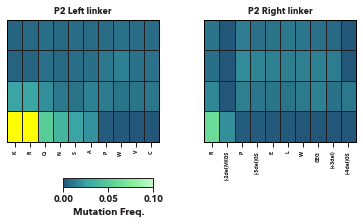

In [13]:
#--- Load previously generated linker frequency data ---
all_left_linkers = pd.DataFrame(dtype=float)
all_right_linkers = pd.DataFrame(dtype=float)
barcodes = ["13", "16", "19", "21"]

#--- Read in linker frequency data for each barcode ---
for barcode in barcodes:
    FigFolder = f"final_output/Nanopore_P0115/barcode{barcode}/"

    left_linkers = pd.read_csv(f"{FigFolder}/linker_distribution_R1.csv", index_col=0).T
    left_linkers.index = [barcode]
    all_left_linkers = pd.concat([all_left_linkers, left_linkers], axis=0)

    right_linkers = pd.read_csv(f"{FigFolder}/linker_distribution_R2.csv", index_col=0).T
    all_right_linkers = pd.concat([all_right_linkers, right_linkers], axis=0)

#--- Standardize indices and fill missing values with 0 ---
all_right_linkers.index = barcodes
all_left_linkers.index = barcodes
all_right_linkers.fillna(0, inplace=True)
all_left_linkers.fillna(0, inplace=True)

#--- Convert percentages to mutation rates (range: 0–1) ---
all_right_linkers /= 100
all_left_linkers /= 100

#--- Filter top n linker variants with highest variance across barcodes ---
n_linkers = 10

left_vars = all_left_linkers.var()
left_quantile_threshold = np.percentile(left_vars, 100 - (n_linkers / all_left_linkers.shape[1]) * 100)
left_top_indices = [i for i, var in enumerate(left_vars) if var >= left_quantile_threshold]
left_top_vars = all_left_linkers.iloc[:, left_top_indices]

right_vars = all_right_linkers.var()
right_quantile_threshold = np.percentile(right_vars, 100 - (n_linkers / all_right_linkers.shape[1]) * 100)
right_top_indices = [i for i, var in enumerate(right_vars) if var >= right_quantile_threshold]
right_top_vars = all_right_linkers.iloc[:, right_top_indices]

#--- Sort linker variants by their abundance on the last barcode (day) ---
right_top_vars = right_top_vars.sort_values(right_top_vars.last_valid_index(), axis=1, ascending=False)
left_top_vars = left_top_vars.sort_values(left_top_vars.last_valid_index(), axis=1, ascending=False)

#--- Generate heatmaps for linker variant dynamics ---
fig, ax = plt.subplots(1, 2, figsize=(6.25, 2.25))
fig.subplots_adjust(wspace=0.3)

my_cmap = custom_cmap
my_cmap.set_over('Yellow')

#--- Left linker heatmap ---
sns.heatmap(left_top_vars, cmap=my_cmap, vmax=0.10, ax=ax[0], cbar=False,
            yticklabels=False, xticklabels=True, linecolor="#231F20", linewidths=1)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_title("P2 Left linker")
for label in ax[0].get_xticklabels():
    label.set_fontsize(5)
for spine in ax[0].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')

#--- Right linker heatmap ---
sns.heatmap(right_top_vars, cmap=my_cmap, vmax=0.10, ax=ax[1], cbar=False,
            yticklabels=False, xticklabels=True, linecolor="#231F20", linewidths=1)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[1].set_title("P2 Right linker")
for label in ax[1].get_xticklabels():
    label.set_fontsize(5)
for spine in ax[1].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')

norm = mcolors.Normalize(vmin=0, vmax=0.10)
cbar_ax = fig.add_axes([0.25, -0.15, 0.2, 0.05])
cb = plt.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=my_cmap),
    cax=cbar_ax,
    orientation='horizontal'
)
cb.set_label("Mutation Freq.", fontsize=10)
cb.ax.tick_params(labelsize=9)

plt.show()

#--- Optional: Save the figure ---
# plt.savefig(f"final_output/Nanopore_P0115/linker_evolution_heatmap{'_'.join(barcodes)}.png", bbox_inches="tight")
# plt.savefig(f"final_output/Nanopore_P0115/linker_evolution_heatmap{'_'.join(barcodes)}.pdf", bbox_inches="tight", dpi=600)


## Figure S14E: Dotplot comparing enrichment after one mutagenesis passage on the Linker library  versus final enrichment after POGO-PANCE.
----------------------------
Dot plot comparing the percentage of each linker variant after one passage of RAMPhaGE mutagenesis (x-axis) to the final enrichment after POGO-PANCE selection (y-axis) in pool P2. Select linker residues are labeled.


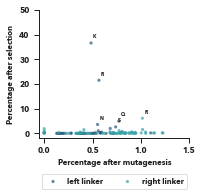

In [8]:
# === Load linker distribution data for each barcode and read direction ===

left_linker_BC1 = pd.read_csv("final_output/Nanopore_P0115/barcode13/linker_distribution_R1.csv", index_col=0).T
right_linker_BC1 = pd.read_csv("final_output/Nanopore_P0115/barcode13/linker_distribution_R2.csv", index_col=0).T

left_linker_BC2 = pd.read_csv("final_output/Nanopore_P0115/barcode21/linker_distribution_R1.csv", index_col=0).T
right_linker_BC2 = pd.read_csv("final_output/Nanopore_P0115/barcode21/linker_distribution_R2.csv", index_col=0).T

# === Collect all unique linker variants across all barcodes (BC1, BC2, BC3) ===

all_right_linkers_vars = list(set(list(right_linker_BC1.columns) + list(right_linker_BC2.columns)))
all_right_linker_perc = pd.DataFrame(columns = all_right_linkers_vars, index = ["BC1", "BC2"], data = 0, dtype=np.float64)

for linker in all_right_linkers_vars: 
    if linker in right_linker_BC1.columns:
        all_right_linker_perc.loc["BC1", linker] = right_linker_BC1.loc["0", linker]
    if linker in right_linker_BC2.columns:
        all_right_linker_perc.loc["BC2", linker] = right_linker_BC2.loc["0", linker] 

all_left_linkers_vars = list(set(list(left_linker_BC1.columns) + list(left_linker_BC2.columns)))
all_left_linker_perc = pd.DataFrame(columns = all_left_linkers_vars, index = ["BC1", "BC2"], data = 0, dtype=np.float64)

for linker in all_left_linkers_vars:
    if linker in left_linker_BC1.columns:
        all_left_linker_perc.loc["BC1", linker] = left_linker_BC1.loc["0",linker]
    if linker in left_linker_BC2.columns:
        all_left_linker_perc.loc["BC2", linker] = left_linker_BC2.loc["0",linker]

# === Scatter plot comparing linker variant percentages before and after selection (BC1 vs BC2) ===

fig, ax = plt.subplots(figsize = (wi3*1.2, hi/3))
compared_to = "BC2"

# --- Plot left linker variants: BC1 vs BC2 ---
plt.scatter(all_left_linker_perc.loc["BC1",:], all_left_linker_perc.loc[compared_to,:], color = "#22577A", edgecolors='none',alpha=0.7, label = "left linker", s = 10)
# --- Plot right linker variants: BC1 vs BC2 ---
plt.scatter(all_right_linker_perc.loc["BC1",:], all_right_linker_perc.loc[compared_to,:], color = "#38A3A5",edgecolors='none', alpha=0.7, label = "right linker", s = 10)

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.tick_params(axis='y', which='major', pad=5)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),ncol =2)
plt.ylim(0, 50)
ax.set_ylim(-2, 50)

plt.xlim(0, 1.5)
ax.set_xlim(-0.05, 1.5) 

plt.xlabel("Percentage after mutagenesis")
plt.ylabel("Percentage after selection")


# --- Annotate points for left linkers with >2% frequency in BC2 ---
for i, (x, y) in enumerate(zip(all_left_linker_perc.loc["BC1", :], all_left_linker_perc.loc[compared_to, :])):
    if y > 2:  
        plt.annotate(all_left_linker_perc.columns[i], (x, y), textcoords="offset points", xytext=(2,5), ha='left', fontsize=5)

for i, (x, y) in enumerate(zip(all_right_linker_perc.loc["BC1", :], all_right_linker_perc.loc[compared_to, :])):
    if y > 2:  
        plt.annotate(all_right_linker_perc.columns[i], (x, y), textcoords="offset points", xytext=(2,5), ha='left', fontsize=5)

# plt.savefig(f"final_output/R36/combined/plots/AA/R36_linker_evolution_scatter_BC1vs{compared_to}.pdf", bbox_inches='tight', dpi = 600)
# plt.savefig(f"final_output/R36/combined/plots/AA/R36_linker_evolution_scatter_BC1vs{compared_to}.png", bbox_inches='tight')

plt.show()
